In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd drive/My\ Drive

/content/drive/My Drive


In [3]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import random
import seaborn as sns
from matplotlib.animation import FuncAnimation

In [4]:
# Create sequences
def create_dataset(series, time_steps):
    X, y = [], []
    for i in range(len(series) - time_steps):
        X.append(series[i:i + time_steps])
        y.append(series[i + time_steps])
    return np.array(X), np.array(y)

def plot_neuron_activity(hidden_states, epoch, num_neurons=10):

    # Flatten the list if hidden_states is a list of lists
    if isinstance(hidden_states[0], list):
        print("Detected list of lists. Flattening hidden_states...")
        hidden_states = [hidden for epoch_states in hidden_states for hidden in epoch_states]

    # Check that hidden_states contains tensors
    assert isinstance(hidden_states[0], torch.Tensor), "Hidden states must be stored as tensors."

    # Number of neurons is determined by the hidden size (third dimension)
    num_neurons = min(num_neurons, hidden_states[0].shape[2])

    # Randomly select neurons to visualize
    selected_neurons = random.sample(range(hidden_states[0].shape[2]), num_neurons)

    plt.figure(figsize=(10, 6))

    # Plot neuron activity for the selected neurons
    for neuron in selected_neurons:
        neuron_activity = [hidden[0, 0, neuron].item() for hidden in hidden_states]  # First layer, first sample
        plt.plot(range(len(hidden_states)), neuron_activity, label=f'Neuron {neuron}')

    plt.title(f'Neuron Activity Across Epochs (Epoch {epoch})')
    plt.xlabel('Epoch')
    plt.ylabel('Neuron Activity')
    plt.legend()
    plt.show()

def plot_weight_evolution(weights_history, epochs):
    """
    Visualize the evolution of weights in the hidden layer as a heatmap.

    Parameters:
    - weights_history: list of torch.Tensor, weight matrices of the hidden layer over epochs.
    """
    # Convert list of tensors to numpy array for visualization
    weight_matrices = [weight.numpy() for weight in weights_history]

    # Get the shape of the weight matrix
    num_epochs = len(weight_matrices)
    num_neurons = weight_matrices[0].shape[0]  # Assuming square weight matrix

    # Create a figure
    plt.figure(figsize=(12, 8))

    # Plot each weight matrix as a subplot
    for i in range( num_epochs):
        plt.subplot(num_epochs, 1, i + 1)
        sns.heatmap(weight_matrices[i], cmap="rocket", cbar=i == num_epochs - 1)
        plt.title(f'Epoch {i+1}')
        plt.xlabel('Neurons')
        plt.ylabel('Neurons')

    plt.tight_layout()
    plt.show()



def save_hidden_states(model, input_sample, hidden_states):
    with torch.no_grad():
        model.eval()
        out, hidden = model.rnn(input_sample)  # Get hidden states from RNN
        hidden_states.append(hidden.detach().cpu())

def save_weights(model, weights_history):
    with torch.no_grad():
        model.eval()
        weights = model.rnn.weight_hh_l0  # Assuming one hidden layer RNN
        weights_history.append(weights.clone())

def plot_weight_evolution_animation(weights_history, save_as='gif'):
    """
    Visualize the evolution of weights in the hidden layer as an animation.

    Parameters:
    - weights_history: list of torch.Tensor, weight matrices of the hidden layer over epochs.
    - save_as: str, either 'video' or 'gif' to save the animation.
    """
    # Convert list of tensors to numpy array for visualization
    weight_matrices = [weight.numpy() for weight in weights_history]

    # Create a figure
    fig, ax = plt.subplots(figsize=(12, 8))

    # Initialize a heatmap
    heatmap = sns.heatmap(weight_matrices[0], cmap="flare", cbar=False, ax=ax)
    plt.title('Weight Evolution at Epoch 1')
    plt.xlabel('Neurons')
    plt.ylabel('Neurons')

    def update(frame):
        ax.clear()  # Clear the previous heatmap
        sns.heatmap(weight_matrices[frame], cmap="flare", cbar=(frame == len(weight_matrices) - 1), ax=ax)
        ax.set_title(f'Weight Evolution at Epoch {frame + 1}')
        ax.set_xlabel('Neurons')
        ax.set_ylabel('Neurons')

    # Create animation
    ani = FuncAnimation(fig, update, frames=len(weight_matrices), repeat=False)

    # Save the animation
    if save_as == 'gif':
        save_path = '/content/drive/My Drive/weight_evolution_lstm.gif'
        ani.save(save_path, writer='pillow', fps=2)
    elif save_as == 'video':
        save_path = '/content/drive/My Drive/weight_evolution_lstm.mp4'
        ani.save(save_path, writer='ffmpeg', fps=2)

    plt.close(fig)  # Close the figure window

In [5]:
# Load the data
''' path_to_data = '/content/drive/My Drive/MG_time_series.csv' for Google Colab
and 'RNN_Course/Data/MG_time_series.csv' for running the codes on the server
'''
path_to_data = 'MG_time_series.csv'
data = pd.read_csv(path_to_data)

In [6]:
# Normalize data
# data = (data - np.mean(data)) / np.std(data)
print(data.shape)

# Convert to Numpy if it's a Pandas object
if isinstance(data, pd.Series) or isinstance(data, pd.DataFrame):
    data = data.values

time_steps = 50  # Number of time steps (sliding window)
X, y = create_dataset(data, time_steps)


# Convert data to PyTorch tensors and reshape for RNN input (samples, time steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))
X_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(y).float()

(9999, 1)


In [7]:
# Splitting the dataset into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.3, random_state=42)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Training set: torch.Size([6964, 50, 1]), torch.Size([6964, 1])
Test set: torch.Size([2985, 50, 1]), torch.Size([2985, 1])


In [8]:
class VanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(VanillaRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.hidden_states = []  # Store hidden states

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)  # Initial hidden state
        out, hidden = self.rnn(x, h0)  # Forward pass through RNN

        # Check if hidden is a tensor and save it
        if isinstance(hidden, torch.Tensor):
            # print(f"Hidden is tensor: {hidden.shape}")  # Debugging output
            self.hidden_states.append(hidden.detach().cpu().clone())  # Store tensor copy
        else:
            print(f"Hidden is not tensor: {type(hidden)}")  # Debugging output

        out = self.fc(out[:, -1, :])  # Pass last time step output through fully connected layer
        return out

    def reset_hidden_states(self):
        """Reset hidden states after each epoch to avoid memory overflow."""
        self.hidden_states = []

In [9]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.hidden_states = []  # Store hidden states

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)  # Initial hidden state
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)  # Initial cell state
        out, (h_n, c_n) = self.lstm(x, (h0, c0))  # LSTM forward

        # Store only the hidden state (h_n) as a tensor
        self.hidden_states.append(h_n.detach().cpu().clone())

        out = self.fc(out[:, -1, :])  # Fully connected layer applied to the last time step
        return out

    def reset_hidden_states(self):
        """Reset hidden states after each epoch to avoid memory overflow."""
        self.hidden_states = []

In [10]:
class VanillaRNNWithXavierInit(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(VanillaRNNWithXavierInit, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

        # Apply Xavier initialization to the RNN weights
        nn.init.xavier_uniform_(self.rnn.weight_ih_l0)  # Input to hidden layer weights
        nn.init.xavier_uniform_(self.rnn.weight_hh_l0)  # Hidden to hidden layer weights

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)  # Initial hidden state
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])  # Take the output from the last time step
        return out

In [11]:
# Set initial parameters
input_size = 1
output_size = 1
hidden_size = 16

Detected list of lists. Flattening hidden_states...


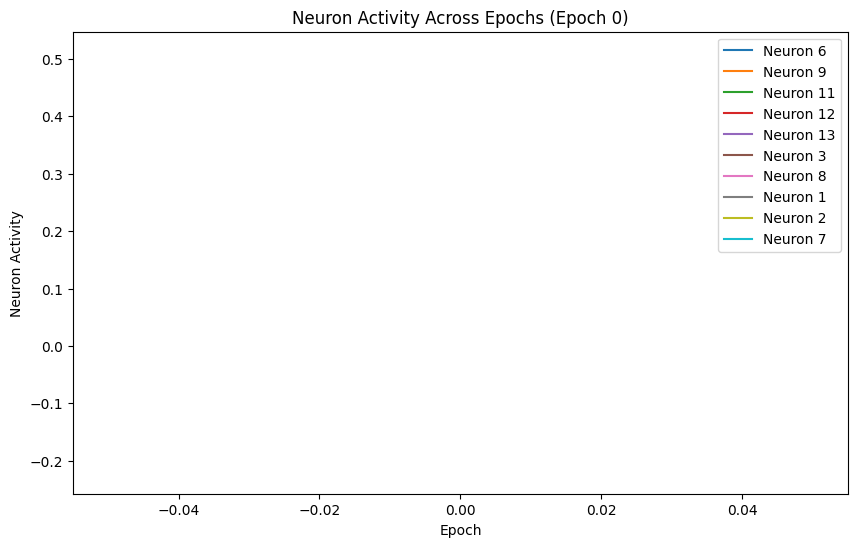

Detected list of lists. Flattening hidden_states...


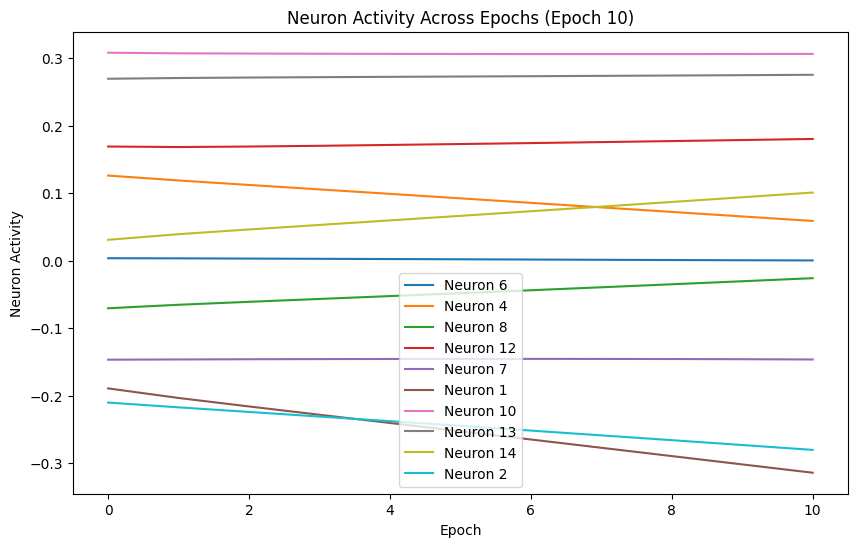

Detected list of lists. Flattening hidden_states...


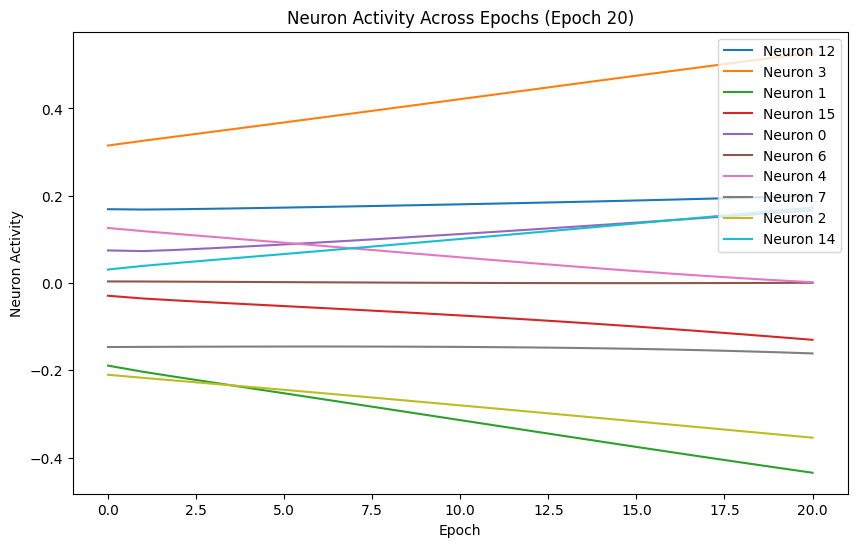

Detected list of lists. Flattening hidden_states...


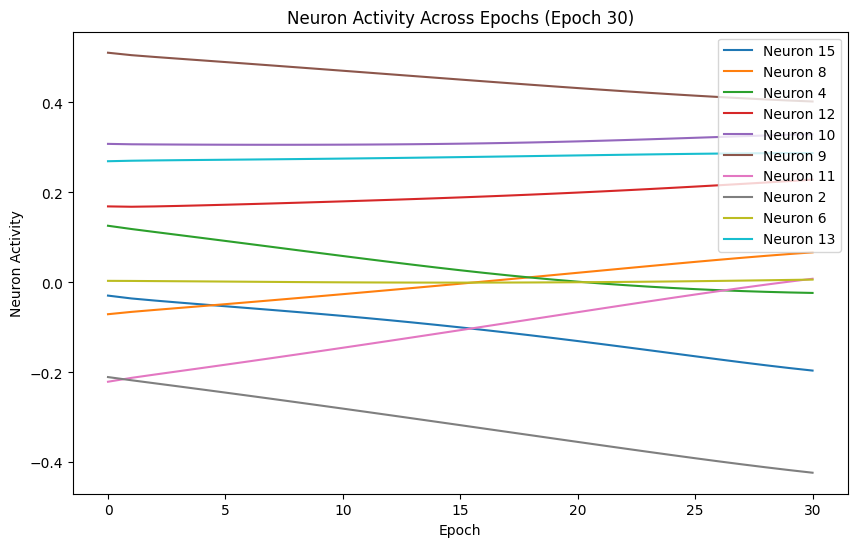

Detected list of lists. Flattening hidden_states...


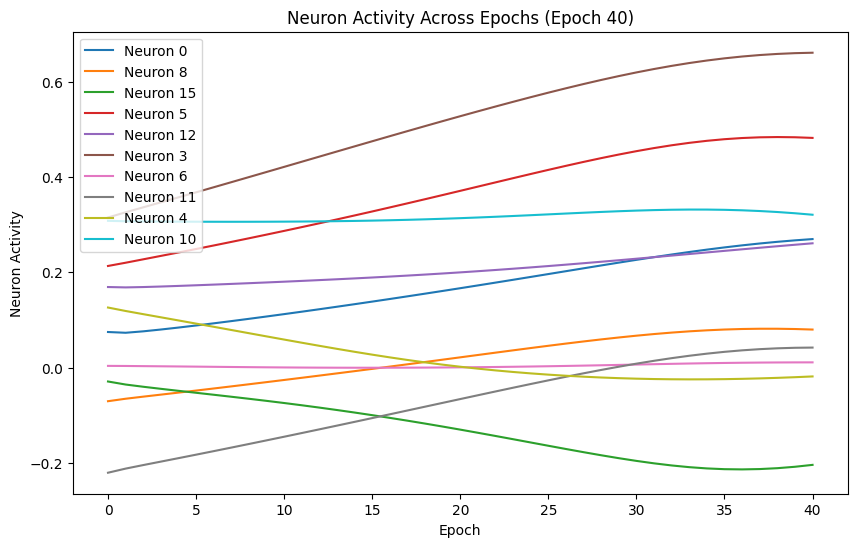

Detected list of lists. Flattening hidden_states...


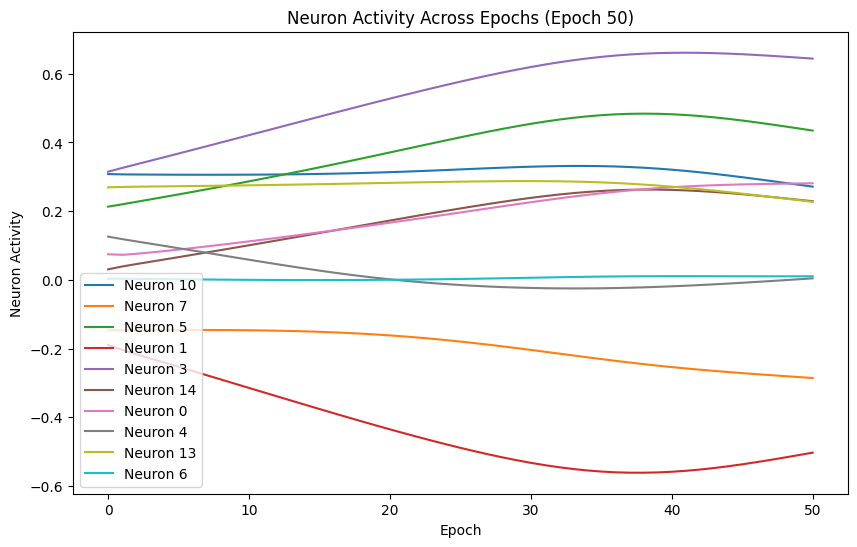

Detected list of lists. Flattening hidden_states...


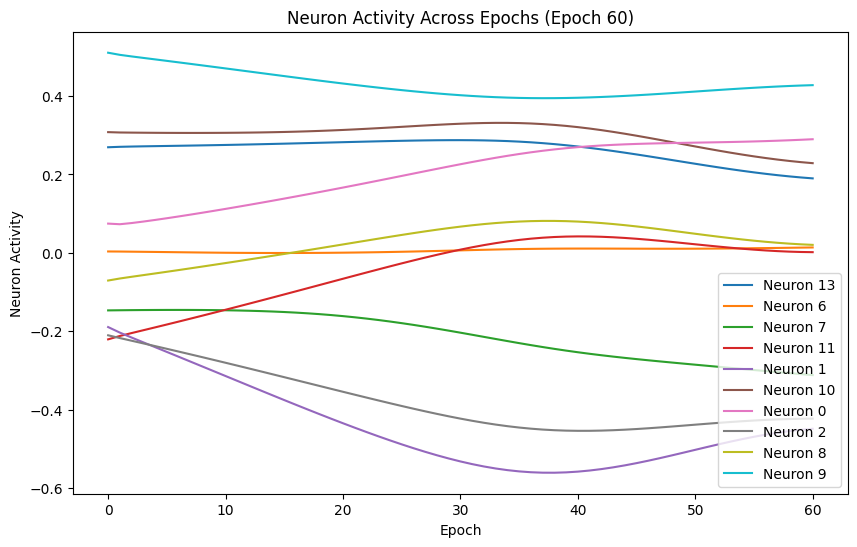

Detected list of lists. Flattening hidden_states...


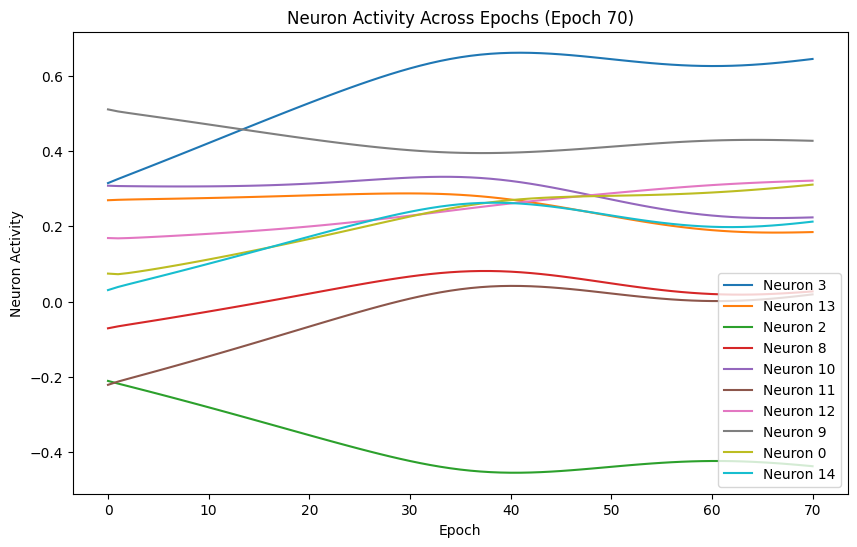

Detected list of lists. Flattening hidden_states...


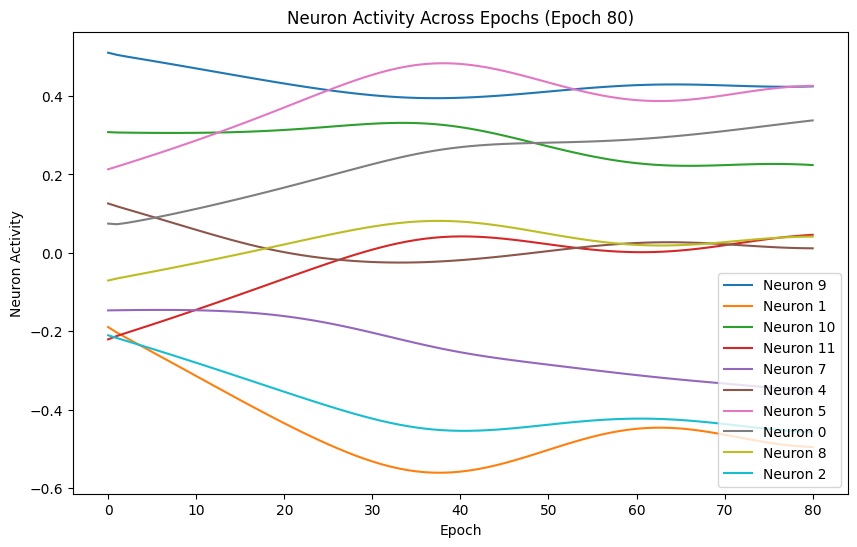

Detected list of lists. Flattening hidden_states...


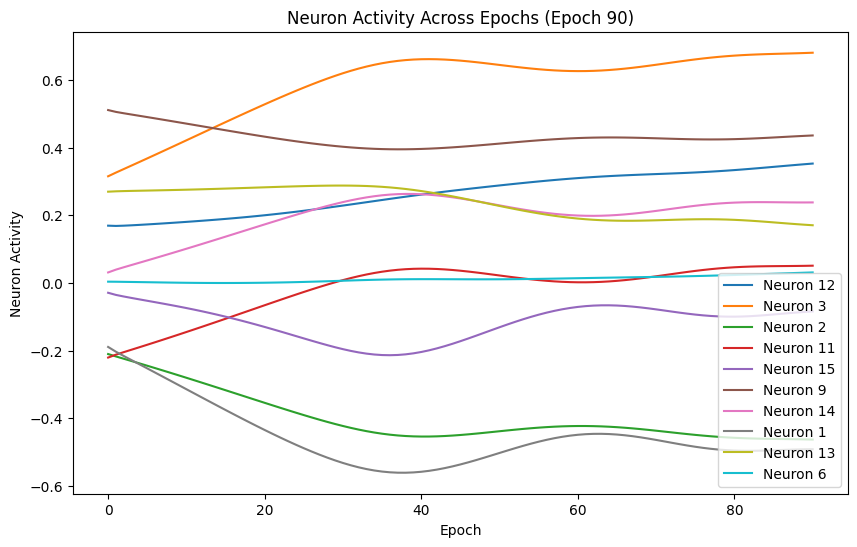

In [12]:
model = VanillaRNN(input_size=input_size, hidden_size=hidden_size,
                   output_size=output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

hidden_states = []
weights_history = []
train_loss_epoch = []

epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()

    # Append training loss for this epoch
    train_loss_epoch.append(loss.item())

    # print(f"Epoch {epoch}: Hidden States Size = {len(model.hidden_states)}")  # Check size
    # print(f"Epoch {epoch}: Hidden State Type = {type(model.hidden_states[0])}")  # Check type
    # print(f"Epoch {epoch}: Hidden State Shape = {model.hidden_states[0].shape}")  # Check shape

    # Store hidden states for visualization
    hidden_states.append(model.hidden_states)
    weights_history.append(model.rnn.weight_hh_l0.clone().detach().cpu())

    # Reset hidden states after each epoch
    model.reset_hidden_states()

    if epoch % 10 == 0:
      plot_neuron_activity(hidden_states, epoch)
    # plot_weight_evolution(weights_history, epoch)
plot_weight_evolution_animation(weights_history, save_as='video')

Test Loss: 0.007785236928611994
Figure saved as PDF to: /content/drive/My Drive/predicted_vs_true_timeseries.pdf


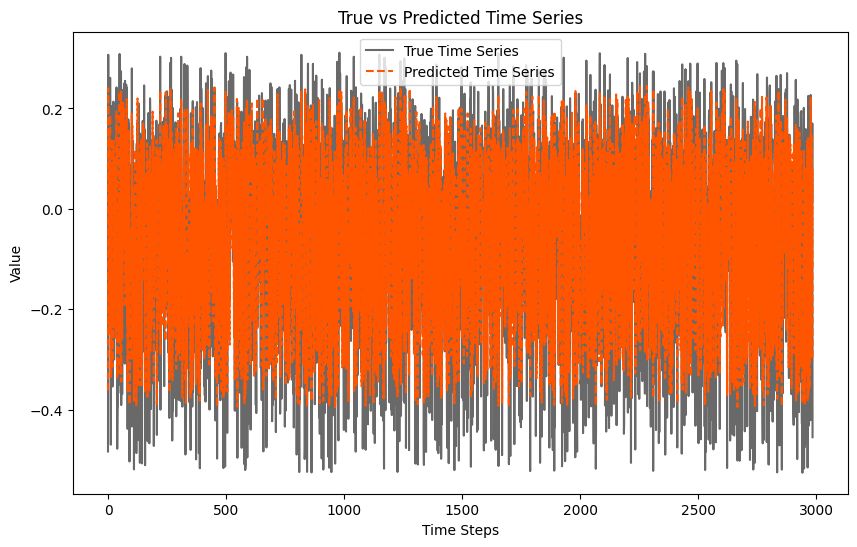

In [13]:
test_output = model(X_test)
test_loss = criterion(test_output, y_test)

print(f"Test Loss: {test_loss.item()}")

# Convert tensors to numpy arrays for plotting
y_test_np = y_test.detach().numpy()
test_output_np = test_output.detach().numpy()

# Plot the true vs predicted time series
save_path = '/content/drive/My Drive/predicted_vs_true_timeseries.pdf'
plt.figure(figsize=(10, 6))
plt.plot(y_test_np, label='True Time Series', color='#696969')
plt.plot(test_output_np, label='Predicted Time Series', color='#FF5500', linestyle='dashed')
plt.title('True vs Predicted Time Series')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()

# Save the figure as a PDF file
# plt.savefig(save_path, format='pdf')

print(f"Figure saved as PDF to: {save_path}")

Detected list of lists. Flattening hidden_states...


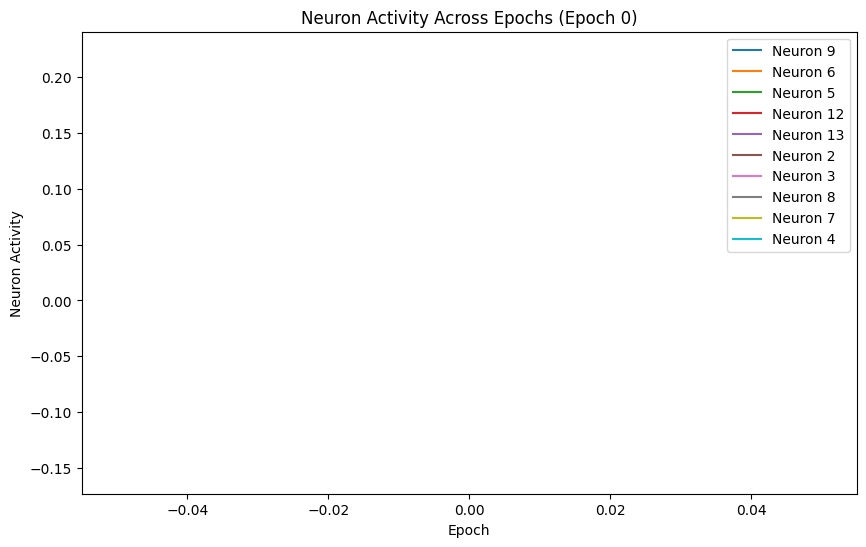

Detected list of lists. Flattening hidden_states...


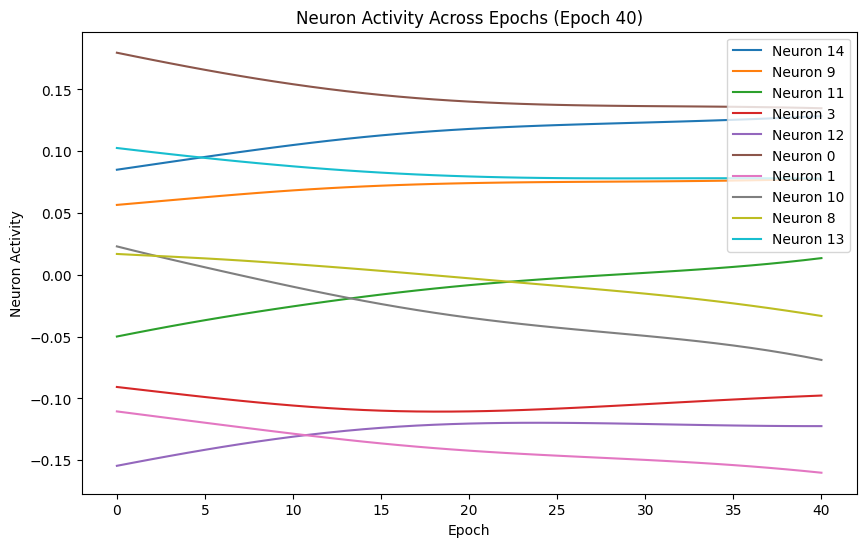

Detected list of lists. Flattening hidden_states...


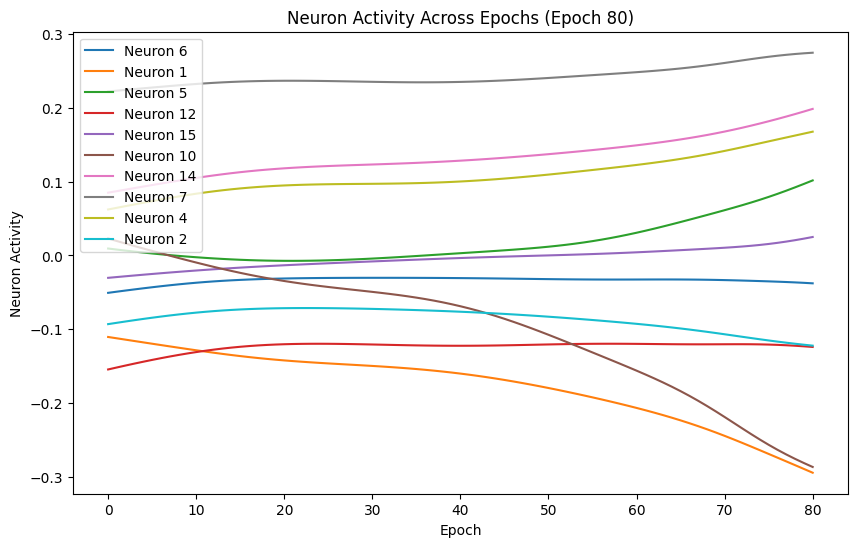

Detected list of lists. Flattening hidden_states...


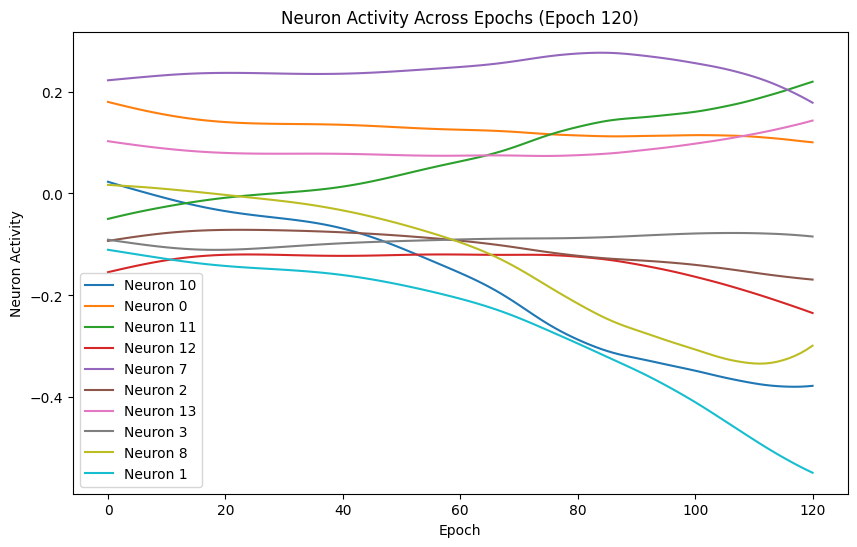

Detected list of lists. Flattening hidden_states...


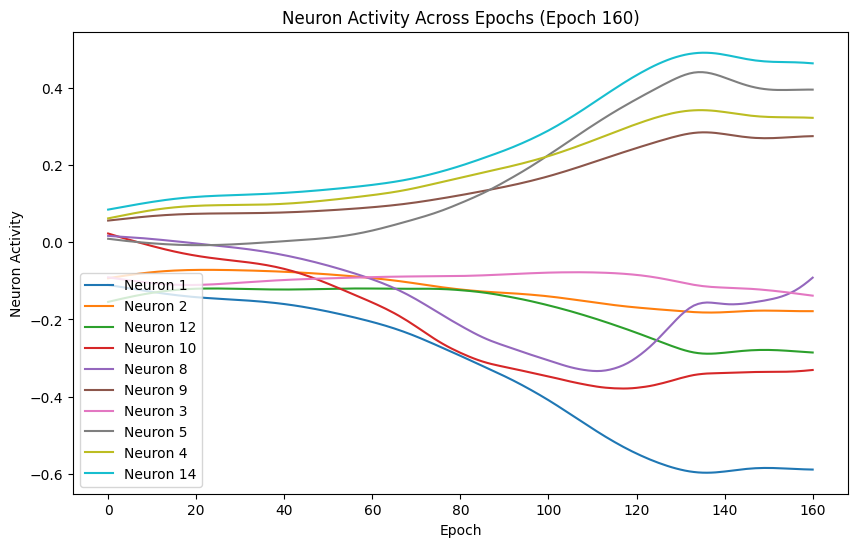

In [15]:
model = LSTMModel(input_size=input_size, hidden_size=hidden_size,
                   output_size=output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

hidden_states = []
weights_history = []
train_loss_epoch = []

epochs = 200
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()

    # Append training loss for this epoch
    train_loss_epoch.append(loss.item())

    # print(f"Epoch {epoch}: Hidden States Size = {len(model.hidden_states)}")  # Check size
    # print(f"Epoch {epoch}: Hidden State Type = {type(model.hidden_states[0])}")  # Check type
    # print(f"Epoch {epoch}: Hidden State Shape = {model.hidden_states[0].shape}")  # Check shape

    # Store hidden states for visualization
    hidden_states.append(model.hidden_states)
    hidden_to_hidden_weights = model.lstm.weight_hh_l0 # [4*hidden_size, hidden_size]

    input_gate = hidden_to_hidden_weights[:hidden_size] #[hidden_size, hidden_size]
    forget_gate = hidden_to_hidden_weights[hidden_size:2*hidden_size]
    cell_gate = hidden_to_hidden_weights[2*hidden_size:3*hidden_size]
    output_gate = hidden_to_hidden_weights[3*hidden_size:]


    # print(input_gate.shape, forget_gate.shape, cell_gate.shape, output_gate.shape)

    # weights_history.append(model.lstm.weight_hh_l0.clone().detach().cpu())
    weights_history.append(input_gate.clone().detach().cpu())

    # Reset hidden states after each epoch
    model.reset_hidden_states()

    if epoch % 40 == 0:
      plot_neuron_activity(hidden_states, epoch)
    # plot_weight_evolution(weights_history, epoch)
plot_weight_evolution_animation(weights_history, save_as='gif')

Test Loss: 0.0014058008091524243


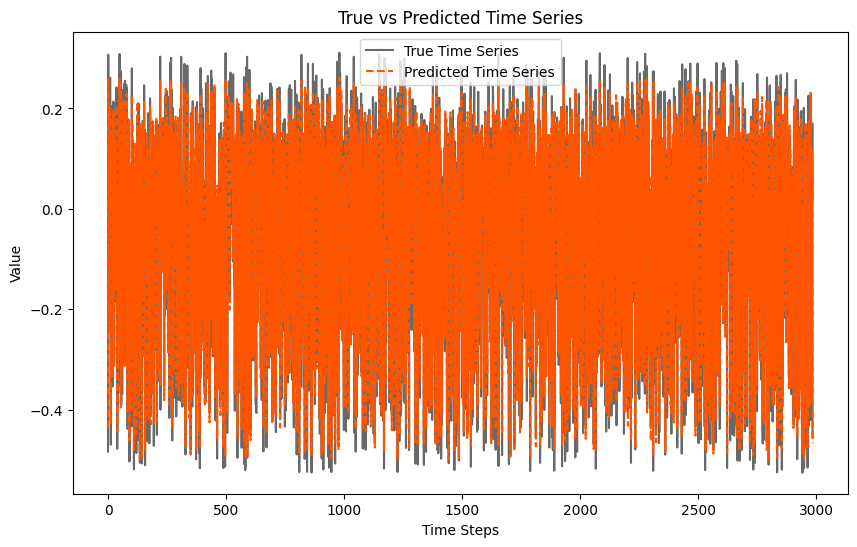

In [16]:
test_output = model(X_test)
test_loss = criterion(test_output, y_test)

print(f"Test Loss: {test_loss.item()}")

# Convert tensors to numpy arrays for plotting
y_test_np = y_test.detach().numpy()
test_output_np = test_output.detach().numpy()

# Plot the true vs predicted time series

plt.figure(figsize=(10, 6))
plt.plot(y_test_np, label='True Time Series', color='#696969')
plt.plot(test_output_np, label='Predicted Time Series', color='#FF5500', linestyle='dashed')
plt.title('True vs Predicted Time Series')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()


In [ ]:
pip install echoes

test r2 score 0.5434092985991135


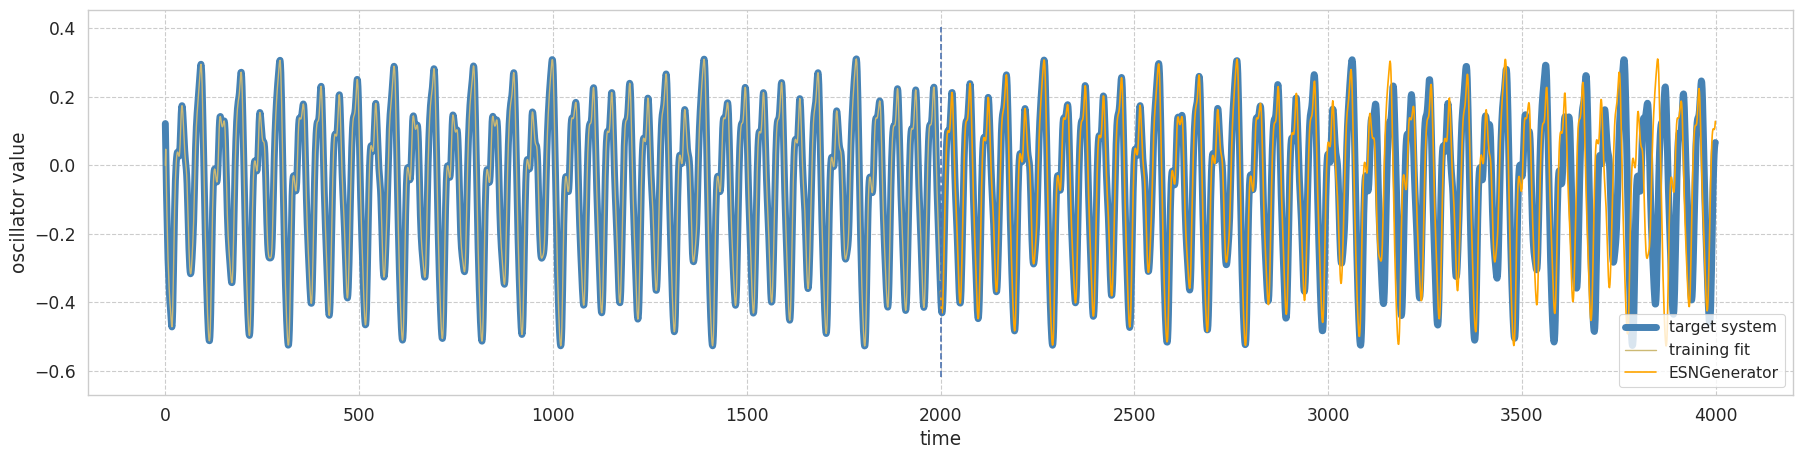

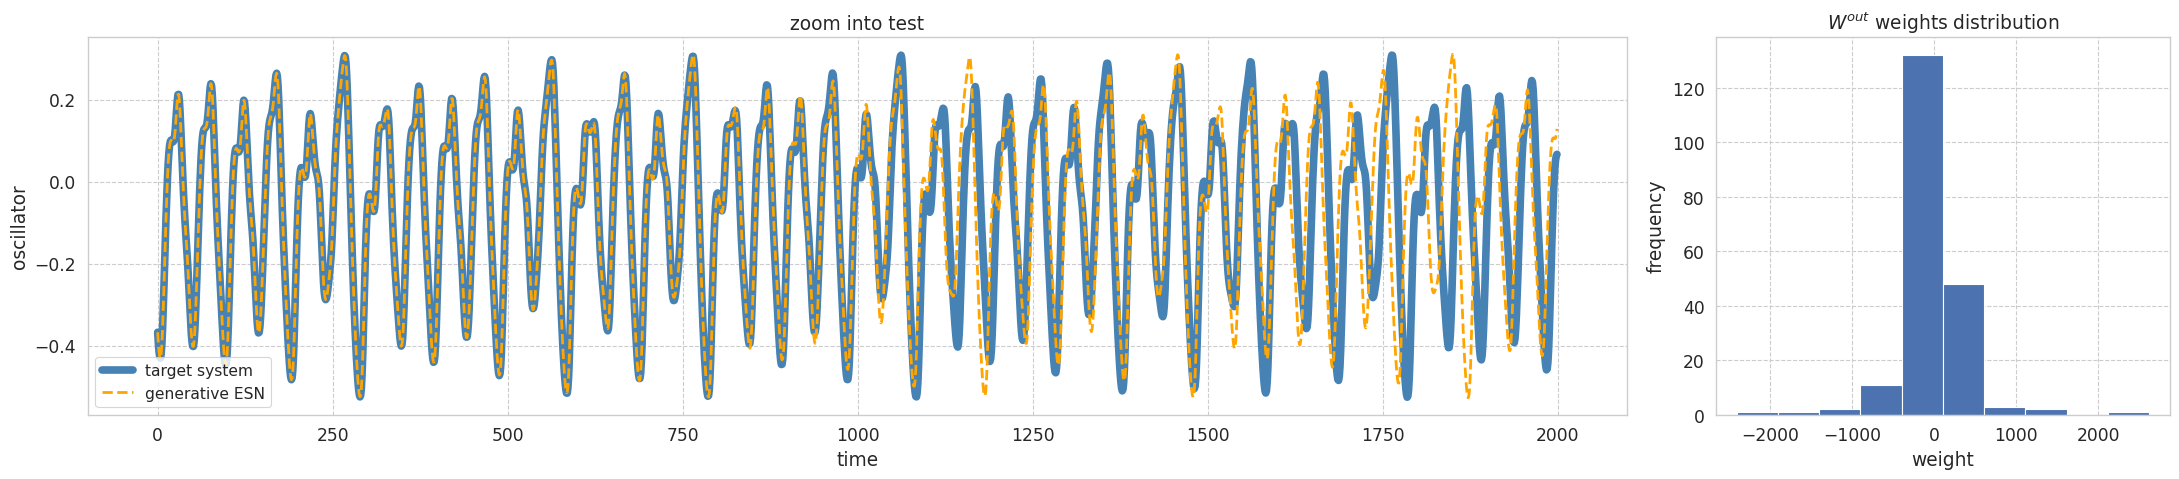

In [18]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from echoes import ESNGenerator
from echoes.datasets import load_mackeyglasst17
from echoes.plotting import plot_predicted_ts, set_mystyle

set_mystyle()  # optional, set aesthetics


# Load and split data
mackey_ts = load_mackeyglasst17()
n_train_steps, n_test_steps = 2000, 2000
n_total_steps = n_train_steps + n_test_steps

y_train, y_test = train_test_split(
    mackey_ts,
    train_size=n_train_steps,
    test_size=n_test_steps,
    shuffle=False
)

esn = ESNGenerator(
    n_steps=n_test_steps,
    n_reservoir=200,
    spectral_radius=1.25,
    leak_rate=.4,
    random_state=42,
)
# Fit the model. Inputs is None because we only have the target time series
esn.fit(X=None, y=y_train)

y_pred = esn.predict()
print("test r2 score", r2_score(y_test, y_pred))

# Plot training and test
plt.figure(figsize=(22, 5))
plt.plot(mackey_ts[: n_total_steps], 'steelblue', linewidth=5, label="target system")
plt.plot(esn.training_prediction_, color="y", linewidth=1, label="training fit")
plt.plot(range(n_train_steps, n_total_steps), y_pred,'orange', label="ESNGenerator")
plt.ylabel("oscillator value")
plt.xlabel('time')
lo, hi = plt.ylim()
plt.vlines(n_train_steps, lo-.05, hi+.05, linestyles='--')
plt.legend(fontsize='small')

# Plot test alone
plt.figure(figsize=(22, 5))
plt.subplot(1, 4, (1, 3))
plt.title("zoom into test")
plt.plot(y_test,
         color="steelblue",
         label="target system",
         linewidth=5.5)
plt.xlabel('time')

plt.plot(y_pred,
         linestyle='--',
         color="orange",
         linewidth=2,
         label="generative ESN",)
plt.ylabel("oscillator")
plt.xlabel('time')
plt.legend(fontsize='small')

plt.subplot(1, 4, 4)
plt.title(r"$W^{out}$ weights distribution")
plt.xlabel('weight')
plt.ylabel('frequency')
plt.hist(esn.W_out_.flat)
plt.tight_layout();